In [1]:
import numpy as np
import warnings
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. Import your custom engine
from data_loader import MarketDataLoader
from quant_math_engine import bs_call_price, implied_volatility

# 2. Load Data 
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"
loader = MarketDataLoader(BASE_DIR)

TARGET_DATE = '2024-01-10'
TARGET_EXDATE = '2024-02-16'
state = loader.get_market_state(TARGET_DATE, TARGET_EXDATE, strike_bound_pct=0.10)

S0, T, r, q = state['S0'], state['T'], state['r'], state['q']
market_strikes, market_prices = state['strikes'], state['prices']

# 3. Calculate Market IVs
target_ivs, valid_strikes = [], []
for i, K in enumerate(market_strikes):
    iv = implied_volatility(market_prices[i], S0, K, T, r, q)
    if not np.isnan(iv):
        target_ivs.append(iv)
        valid_strikes.append(K)

valid_strikes = np.array(valid_strikes)
target_ivs = np.array(target_ivs)
print(f"✅ Ready! Targeting {len(valid_strikes)} liquid strikes.")

Loading Options, Spot, Yield, and Dividend Data into memory...
✅ Data Loaded Successfully.
✅ Ready! Targeting 352 liquid strikes.


In [2]:
# --- BLACK-SCHOLES OBJECTIVE FUNCTION ---
def bs_objective(params):
    sigma = params[0]
    error = 0.0
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, K in enumerate(valid_strikes):
            # Price the option using a CONSTANT volatility
            m_price = bs_call_price(sigma, S0, K, T, r, q)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv): error += 5.0
            else: error += (m_iv - target_ivs[i])**2
                
    return error / len(valid_strikes)

# Guess 15% volatility
bs_guess = [0.15] 
bs_bounds = [(0.01, 1.0)]

print("Optimizing Constant Black-Scholes Volatility...")
res_bs = minimize(bs_objective, bs_guess, method='L-BFGS-B', bounds=bs_bounds)

best_sigma = res_bs.x[0]

print(f"✅ Finished!")
print(f"Optimal Constant Volatility: {best_sigma * 100:.2f}%")
print(f"Mean Squared Error: {res_bs.fun:.6f}")

Optimizing Constant Black-Scholes Volatility...
✅ Finished!
Optimal Constant Volatility: 13.94%
Mean Squared Error: 0.001505


Generating Black-Scholes Flat Line vs Market Smile...


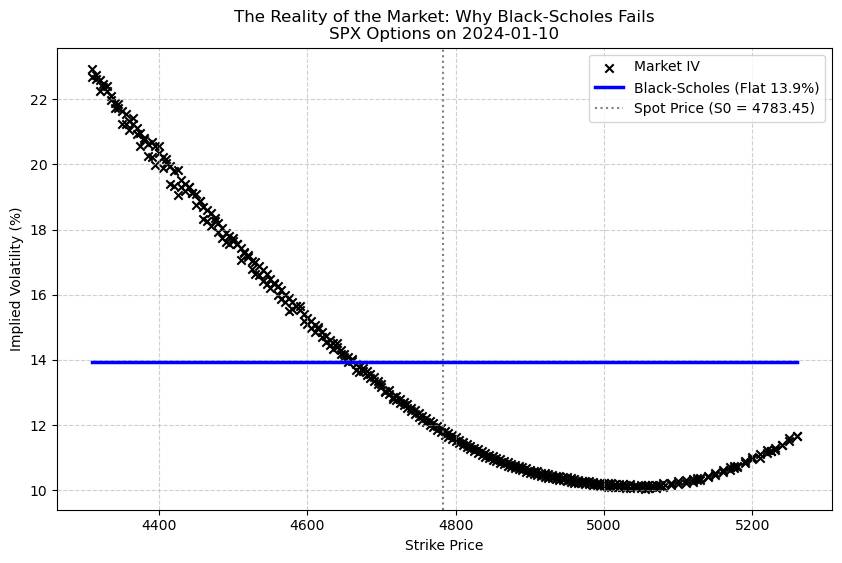

In [3]:
print("Generating Black-Scholes Flat Line vs Market Smile...")

# Black-Scholes assumes IV is exactly the same across every single strike
clean_strikes = np.linspace(min(valid_strikes), max(valid_strikes), 50)
bs_iv_line = np.full_like(clean_strikes, best_sigma) * 100

plt.figure(figsize=(10, 6))

# Plot Market Data
plt.scatter(valid_strikes, target_ivs * 100, color='black', label='Market IV', marker='x')

# Plot Black Scholes
plt.plot(clean_strikes, bs_iv_line, color='blue', label=f'Black-Scholes (Flat {best_sigma*100:.1f}%)', linewidth=2.5)

plt.axvline(S0, color='gray', linestyle=':', label=f'Spot Price (S0 = {S0})')
plt.title(f"The Reality of the Market: Why Black-Scholes Fails\nSPX Options on {TARGET_DATE}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()